In [ ]:
# Create enviroment with conda
#conda create -n myenv python=3.10
# IMPORTANT: Make sure you are on 3.10
%pip install qiskit==1.4.2 qiskit-ibm-runtime qiskit-aer qiskit-machine-learning 'qiskit-machine-learning[sparse]' qiskit-algorithms
%pip install tensorflow
%pip install matplotlib
%pip install pylatexenc

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import TwoLocal, RealAmplitudes
from qiskit_aer import Aer
from qiskit_machine_learning.neural_networks import SamplerQNN # Downgrade to qiskit 1.x so is compatible with qiskit-machine-learning 0.8.2
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import plot_histogram

import tensorflow as tf
import copy
import matplotlib.pyplot as plt
import time

2025-05-19 13:16:05.753531: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-19 13:16:05.756986: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-19 13:16:05.765070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747653365.778407   99065 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747653365.782282   99065 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747653365.794477   99065 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
# Get backend

backend = Aer.get_backend('aer_simulator_statevector')

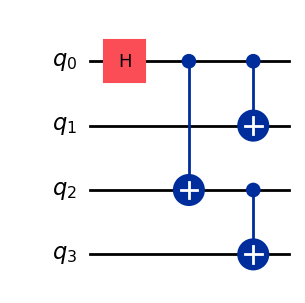

In [4]:
# Create real data generator
def generate_ghz(num_qubits):
    qc = QuantumCircuit(num_qubits)
    qc.h(0)
 
    l = int(np.ceil(np.log2(num_qubits)))
    for m in range(l, 0, -1):
        for k in range(0, num_qubits, 2 ** m):
            if k + 2 ** (m - 1) >= num_qubits: continue
            qc.cx(k, k + 2 ** (m - 1))
    return qc

REAL_DIST_NQUBITS = 4
real_circuit = generate_ghz(REAL_DIST_NQUBITS)
real_circuit.draw('mpl')

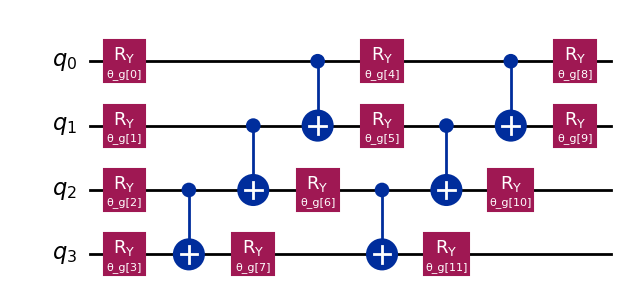

In [5]:
# Create generator

# generator = TwoLocal(REAL_DIST_NQUBITS,
#                      # Parameterized single qubit rotations
#                      ['ry', 'rz'],
#                      'cz',  # Entangling gate
#                      'full', # Entanglement structure: all to all
#                      reps=2, # Number of layers
#                      parameter_prefix='θ_g',
#                      name='Generator')

generator = RealAmplitudes(REAL_DIST_NQUBITS,
                     reps=2, # Number of layers
                     parameter_prefix='θ_g',
                     name='Generator')
generator = generator.decompose() # decompose into standard gates
generator.draw('mpl')

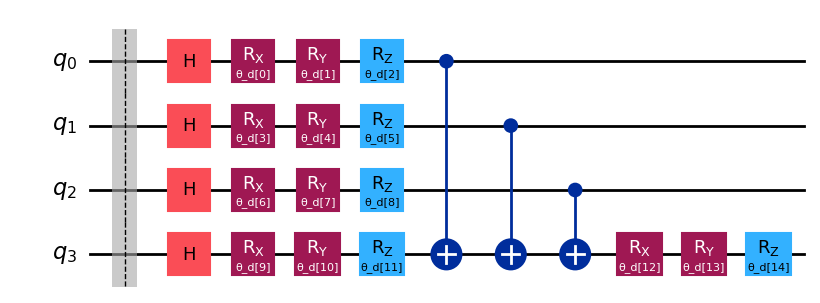

In [6]:
# Create discriminator
def generate_discriminator(num_qubits, disc_weights):
    qc = QuantumCircuit(num_qubits, name="Discriminator")
    param_index = 0

    qc.barrier()

    #for?
    # qc.h(0)

    for q in range(num_qubits):
        qc.h(q)
        qc.rx(disc_weights[param_index], q); param_index += 1
        qc.ry(disc_weights[param_index], q); param_index += 1
        qc.rz(disc_weights[param_index], q); param_index += 1
    
    for i in range(num_qubits - 1):
        qc.cx(i, num_qubits - 1)
    # l = int(np.ceil(np.log2(num_qubits)))
    # for m in range(1, l+1):
    #     print("m:", m)
    #     for k in range(1, num_qubits, 2 ** m):
    #         print("k:", k)
    #         if k + 2 ** (m - 1) >= num_qubits: continue
    #         qc.cx(k, k + 2 ** (m - 1))

    qc.rx(disc_weights[param_index], num_qubits-1); param_index += 1
    qc.ry(disc_weights[param_index], num_qubits-1); param_index += 1
    qc.rz(disc_weights[param_index], num_qubits-1); param_index += 1
    
    #qc.measure(num_qubits-1, 0) # For real hardware execution
    return qc
disc_weights = ParameterVector('θ_d', 3*(REAL_DIST_NQUBITS+1))
discriminator = generate_discriminator(REAL_DIST_NQUBITS, disc_weights)
discriminator.draw('mpl')

In [7]:
# Parameters
N_GPARAMS = generator.num_parameters
N_DPARAMS = discriminator.num_parameters
N_GPARAMS, N_DPARAMS

(12, 15)

In [8]:
# Connect real data and discriminator
real_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS)
real_disc_circuit.compose(real_circuit, inplace=True)
real_disc_circuit.compose(discriminator, inplace=True)

In [9]:
# Connect generator and discriminator
gen_disc_circuit = QuantumCircuit(REAL_DIST_NQUBITS)
gen_disc_circuit.compose(generator, inplace=True)
gen_disc_circuit.compose(discriminator, inplace=True)

In [10]:
# Cost calculation functions

def generator_cost(gen_params):
    curr_params = np.append(disc_params.numpy(),
                            gen_params.numpy())
    state_probs = Statevector(gen_disc_circuit
                              .assign_parameters(curr_params)
                             ).probabilities()
    
    prob_fake_true = np.sum(state_probs[2**(REAL_DIST_NQUBITS-1):]) #CAMBIA
    cost = -prob_fake_true
    return cost

def discriminator_cost(disc_params):
    curr_params = np.append(disc_params.numpy(),
                            gen_params.numpy())
    gendisc_probs = Statevector(gen_disc_circuit
                                .assign_parameters(curr_params)
                               ).probabilities()
    realdisc_probs = Statevector(real_disc_circuit.
                                 assign_parameters(disc_params.numpy())
                                ).probabilities()
    # Get total prob of measuring |1> on last qubit
    prob_fake_true = np.sum(gendisc_probs[2**(REAL_DIST_NQUBITS-1):])
    # Get total prob of measuring |1> on q2
    prob_real_true = np.sum(realdisc_probs[2**(REAL_DIST_NQUBITS-1):])
    cost = prob_fake_true - prob_real_true
    return cost

In [11]:
# Performance measurement function: uses Kullback Leibler Divergence to measures the distance between two distributions

def calculate_kl_div(model_distribution: dict, target_distribution: dict):
    kl_div = 0
    for bitstring, p_data in target_distribution.items():
        if np.isclose(p_data, 0, atol=1e-8):
            continue
        if bitstring in model_distribution.keys():
            kl_div += (p_data * np.log(p_data)
                 - p_data * np.log(model_distribution[bitstring]))
        else:
            kl_div += p_data * np.log(p_data) - p_data * np.log(1e-6)
    return kl_div

In [12]:
# Use SamplerQNN to compile the parameterized circuit and handle calculation of the gradient recipes.

sampler = Sampler(mode=backend)

# specify QNN to update generator weights
gen_qnn = SamplerQNN(circuit=gen_disc_circuit,  # parameterized circuit
                     # frozen input arguements (discriminator weights)
                     input_params=gen_disc_circuit.parameters[:N_DPARAMS],
                     # differentiable weights (generator weights)
                     weight_params=gen_disc_circuit.parameters[N_DPARAMS:],
                     sparse=True, # returns sparse probability vector
                     sampler=sampler)

# specify QNNs to update discriminator weights regarding to fake data
disc_fake_qnn = SamplerQNN(circuit=gen_disc_circuit, # parameterized circuit
                           # frozen input arguments (generator weights)
                           input_params=gen_disc_circuit.parameters[N_DPARAMS:],
                           # differentiable weights (discrim. weights)
                           weight_params=gen_disc_circuit.parameters[:N_DPARAMS],
                           sparse=True, # get sparse probability vector
                           sampler=sampler)

# # specify QNNs to update discriminator weights regarding to real data
disc_real_qnn = SamplerQNN(circuit=real_disc_circuit, # parameterized circuit
                           input_params=[], # no input parameters
                           # differentiable weights (discrim. weights)
                           weight_params=gen_disc_circuit.parameters[:N_DPARAMS],
                           sparse=True, # get sparse probability vector
                           sampler=sampler)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [13]:
# Initialize parameters
init_gen_params = np.random.uniform(low=-np.pi,
                                    high=np.pi,
                                    size=(N_GPARAMS,))
init_disc_params = np.random.uniform(low=-np.pi,
                                     high=np.pi,
                                     size=(N_DPARAMS,))

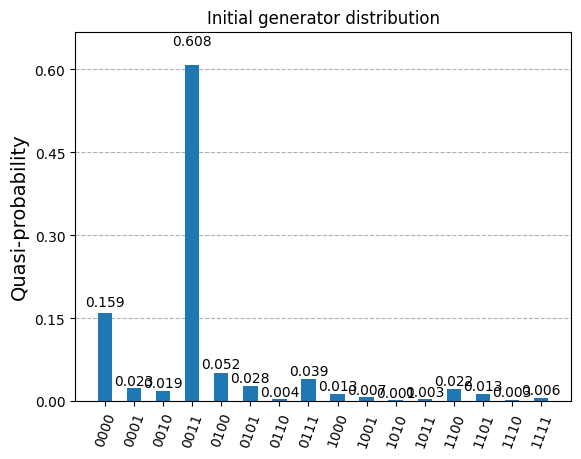

In [14]:
# Display initial generator distribution
init_gen_circuit = generator.assign_parameters(init_gen_params)
init_prob_dict = Statevector(init_gen_circuit).probabilities_dict()

fig, ax1 = plt.subplots(1, 1, sharey=True)
ax1.set_title("Initial generator distribution")
plot_histogram(init_prob_dict, ax=ax1)

In [15]:
# Initialize Adam optimizer from Keras (TensorFlow)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

2025-05-19 13:16:08.798540: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [16]:
def initialize_parameters(conti, training_data_file, parameter_data_file):
    if conti == 1:
        with open(training_data_file) as f:
            lines = f.read().splitlines()
        current_epoch = len(lines)
        gloss, dloss, kl_div = [], [], []
        for line in lines: # Just or graph
            line_data = line.split(";")
            if len(line_data) != 4:
                print("Error in training_data.txt file in line:", line)
            gloss.append(np.float64(line_data[1]))
            dloss.append(np.float64(line_data[2]))
            kl_div.append(np.float64(line_data[3]))

        with open(parameter_data_file) as f:
            line = f.readline()
        line_data = line.split(";")
        if len(line_data) != 3:
            print("Error in parameters.txt file")
        gen_params = tf.Variable(np.array(eval(line_data[0])).astype(float))
        disc_params = tf.Variable(np.array(eval(line_data[1])).astype(float))
        best_gen_params = tf.Variable(np.array(eval(line_data[2])).astype(float))

        file = open(training_data_file,'a')

    else:
        current_epoch = 0
        gloss, dloss, kl_div = [], [], []
        gen_params = tf.Variable(init_gen_params)
        disc_params = tf.Variable(init_disc_params)
        best_gen_params = tf.Variable(init_gen_params)
        file = open(training_data_file,'w')

    return current_epoch, gloss, dloss, kl_div, gen_params, disc_params, best_gen_params, file

In [17]:
# Training

#--- Initialize parameters ---#
training_data_file = 'data/training_data_q' + str(REAL_DIST_NQUBITS) + '.txt' # data folder must exist
parameter_data_file = 'data/parameters_q' + str(REAL_DIST_NQUBITS) + '.txt'
max_epoch = 300
conti = 0 # Continue training from last execution

current_epoch, gloss, dloss, kl_div, gen_params, disc_params, best_gen_params, file = initialize_parameters(conti, training_data_file, parameter_data_file)


#--- Initialize optimizers with loaded parameters ---#
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
    

TABLE_HEADERS = "Epoch | Generator cost | Discriminator cost | KL Div. | Best KL Div. | Time |"
print(TABLE_HEADERS)
start_time = time.time()

#--- Training loop ---#
try: # In case of interruption
    for epoch in range(current_epoch, max_epoch):

        #--- Quantum discriminator parameter updates ---#
        D_STEPS = 5 # N discriminator updates per generator update
        for disc_train_step in range(D_STEPS):
            d_fake = disc_fake_qnn.backward(gen_params, disc_params)[1].todense()[0, 2**(REAL_DIST_NQUBITS-1):] #Backwards returns [n_batch, n_qubits, n_params] shape
            d_fake = np.sum(d_fake, axis=0) # sum of all [n_params] shape gradient for each possible output where last qubit is 1

            d_real = disc_real_qnn.backward([], disc_params)[1].todense()[0, 2**(REAL_DIST_NQUBITS-1):]
            d_real = np.sum(d_real, axis=0)

            grad_dcost = [d_fake[i] - d_real[i] for i in range(N_DPARAMS)]
            grad_dcost = tf.convert_to_tensor(grad_dcost)
            
            discriminator_optimizer.apply_gradients(zip([grad_dcost],
                                                        [disc_params]))
            
            if disc_train_step % D_STEPS == 0:
                dloss.append(discriminator_cost(disc_params))

        #--- Quantum generator parameter updates ---#
        for gen_train_step in range(1):
            grads = gen_qnn.backward(disc_params, gen_params)
            grads = grads[1].todense()[0][2**(REAL_DIST_NQUBITS-1):]

            grads = -np.sum(grads, axis=0)
            grads = tf.convert_to_tensor(grads)

            generator_optimizer.apply_gradients(zip([grads], [gen_params]))
            gloss.append(generator_cost(gen_params))

        #--- Track KL and save best performing generator weights ---#
        gen_checkpoint_circuit = generator.assign_parameters(gen_params.numpy()) # Create test circuit with updated gen parameters
        gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict() # Retrieve probability distribution of current generator
        
        real_prob_dict = Statevector(real_circuit).probabilities_dict() # Constant real probability distribution
        
        current_kl = calculate_kl_div(gen_prob_dict, real_prob_dict)
        kl_div.append(current_kl)
        if np.min(kl_div) == current_kl:
            best_gen_params = copy.deepcopy(gen_params) # New best

        #--- Save progress in file ---#
        file.write(str(epoch) + ";" + str(gloss[-1]) + ";" + str(dloss[-1]) + ";" + str(kl_div[-1]) + "\n")

        if epoch % 10 == 0: # Print progress
            for header, val in zip(TABLE_HEADERS.split('|'),
                                (epoch, gloss[-1], dloss[-1], kl_div[-1], np.min(kl_div), (time.time() - start_time))):
                print(f"{val:.3g} ".rjust(len(header)), end="|")
            start_time = time.time()
            print()
            
#--- Save data in file ---#
finally:
    file.close()
    file = open(parameter_data_file,'w')
    file.write(str(gen_params.numpy().tolist()) + ";" + str(disc_params.numpy().tolist()) + ";" + str(best_gen_params.numpy().tolist()) + "\n")
    file.close()
    
print("Training complete.")


Epoch | Generator cost | Discriminator cost | KL Div. | Best KL Div. | Time |
    0 |         -0.573 |             0.0171 |    2.83 |         2.83 | 4.54 |
   10 |        -0.0951 |             -0.484 |    2.73 |         2.73 | 15.1 |
   20 |        -0.0904 |             -0.426 |    2.85 |         2.66 | 15.1 |
   30 |         -0.139 |             -0.711 |    4.07 |         2.66 | 14.6 |
   40 |         -0.101 |              -0.81 |    3.25 |         2.66 | 15.7 |
   50 |         -0.193 |              -0.69 |    2.36 |         2.36 | 15.1 |
   60 |         -0.381 |             -0.485 |    2.05 |         2.05 | 15.6 |
   70 |         -0.362 |             -0.629 |    1.77 |         1.77 | 15.1 |
   80 |         -0.467 |             -0.525 |     1.7 |         1.68 | 15.4 |
   90 |         -0.474 |             -0.465 |    1.83 |         1.68 | 15.5 |
  100 |         -0.355 |             -0.584 |    1.74 |         1.68 | 15.1 |


KeyboardInterrupt: 

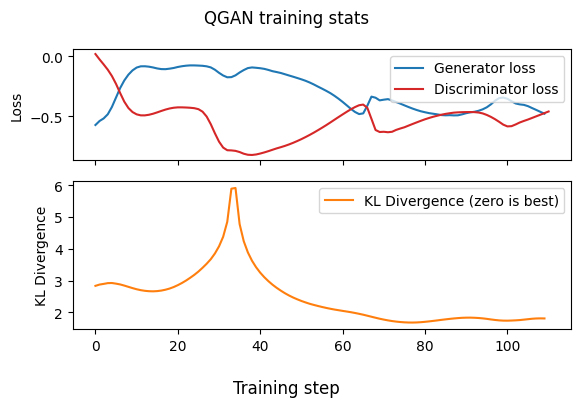

In [18]:
fig, (loss, kl) = plt.subplots(2, sharex=True,
                               gridspec_kw={'height_ratios': [0.75, 1]},
                               figsize=(6,4))
fig.suptitle('QGAN training stats')
fig.supxlabel('Training step')
loss.plot(range(len(gloss)), gloss, label="Generator loss")
loss.plot(range(len(dloss)), dloss, label="Discriminator loss",
          color="C3")
loss.legend()
loss.set(ylabel='Loss')
kl.plot(range(len(kl_div)), kl_div, label="KL Divergence (zero is best)", #AÑADIR LINEA PUNTITOS PA CURRENT MIN KL
        color="C1")
kl.set(ylabel='KL Divergence')
kl.legend()
fig.tight_layout()

In [ ]:
# Create test circuit with new parameters
gen_checkpoint_circuit = generator.assign_parameters(best_gen_params.numpy())
gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict()
real_prob_dict = Statevector(real_circuit).probabilities_dict() # constant
#fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(9,3))
fig, ax1 = plt.subplots(1, 1, sharey=True)
plot_histogram(gen_prob_dict, ax=ax1)
ax1.set_title("Trained generator distribution")
#plot_histogram(real_prob_dict, ax=ax2)
#ax2.set_title("Real distribution")
fig.tight_layout()